In [2]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

BASE_DATA_DIR = "../../data"
ORIGINAL_DATA_DIR = f"{BASE_DATA_DIR}/original/data"

users = pd.read_csv("{}/users.csv.gz".format(ORIGINAL_DATA_DIR), dtype={"gender": "category"})
events = pd.read_csv(
    "{}/events.csv.gz".format(ORIGINAL_DATA_DIR),
    dtype={"event_type": "category"},
    parse_dates=["event_date"]
)
transactions = pd.read_csv(
    "{}/transactions.csv.gz".format(ORIGINAL_DATA_DIR),
    parse_dates=["start_time", "commit_time"]
)
documents = pd.read_csv(
    "{}/documents.csv.gz".format(ORIGINAL_DATA_DIR)
)

In [3]:
tr_merged = transactions.merge(events, on="transaction_token", how="inner")

"""
Cell generated by Data Wrangler.
"""
def clean_data(tr_merged):
    # Drop rows with missing data in columns: 'input', 'type'
    tr_merged.dropna(subset=['input', 'type'], inplace=True)
    # Drop columns: 'user_agent', 'commit_time' and 17 other columns
    tr_merged.drop(columns=['user_agent', 'commit_time', 'start_time', 'challenge_id', 'session_id_x', 'topic_id_x', 'session_closed_x', 'session_type_x', 'session_accepted_x', 'challenge', 'challenge_order', 'challenge_name', 'user_id_y', 'event_date', 'session_id_y', 'topic_id_y', 'session_closed_y', 'session_type_y', 'session_accepted_y'], inplace=True)
    # Rename column 'user_id_x' to 'user_id'
    tr_merged.rename(columns={'user_id_x': 'user_id'}, inplace=True)
    return tr_merged

tr_merged_clean = clean_data(tr_merged.copy())
tr_merged_clean_with_docs = tr_merged_clean.merge(documents, on="document_id", how="inner")
tr_merged_clean_with_docs.head(2)

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,solution,type_x,event_id,...,tracking_data,version,title,type_y,created_time,author_id,content,status,version_comment,topic_id
0,688413,88fdcaad-f73b-46a2-b561-d262f2441442,393211,awd0i1DlVtg6kuMZSkpmHa,75002,PARTIAL,"{""type"": ""MULTI_COLOR_HIGHLIGHT"", ""highlighted...","{""type"": ""MULTI_COLOR_HIGHLIGHT"", ""tokens"": [{...",MULTI_COLOR_HIGHLIGHT,65,...,NaN,4221,NaN,MULTI_COLOR_HIGHLIGHT,2019-07-19 12:28:58.690,29.0,"{""id"": ""awd0i1DlVtg6kuMZSkpmHa"", ""type"": ""MULT...",WORK_IN_PROGRESS,NaN,2045
1,688413,88fdcaad-f73b-46a2-b561-d262f2441442,393211,awd0i1DlVtg6kuMZSkpmHa,75002,PARTIAL,"{""type"": ""MULTI_COLOR_HIGHLIGHT"", ""highlighted...","{""type"": ""MULTI_COLOR_HIGHLIGHT"", ""tokens"": [{...",MULTI_COLOR_HIGHLIGHT,65,...,NaN,4222,6.3A_STIL_RHET_2_farbiges Markieren,MULTI_COLOR_HIGHLIGHT,2019-07-19 12:48:51.942,29.0,"{""id"": ""awd0i1DlVtg6kuMZSkpmHa"", ""type"": ""MULT...",WORK_IN_PROGRESS,NaN,2045


## Save examples of the data to files
The following cell is used to write examples of the data to files for each question type. It is useful to explore the data and to get a better understanding of the data.

In [4]:
question_types = [
    "CLOZE_MATH",
    "CLOZE_TEXT",
    "CLOZE_TEXT_DROPDOWN",
    "DND_GROUP",
    "DND_IN_TEXT",
    "DND_ORDER",
    "DND_PAIRS",
    "FIX_TEXT",
    "GRAPH_CLICK_POINTS",
    "GRAPH_SELECT_SHAPE",
    "GRAPH_SOLUTION_FIELD",
    "HIGHLIGHT",
    "MATH_STEP_BY_STEP",
    "MULTIPLE_CHOICE",
    "MULTI_COLOR_HIGHLIGHT",
    "OPEN_TASK",
    "SEPARATE_TEXT",
    "SOLUTION_FIELD"
]

import os
import json

for q_type in question_types:
    cur = tr_merged_clean_with_docs[(tr_merged_clean_with_docs["type_x"] == q_type) & (tr_merged_clean_with_docs["status"] == "LIVE")]
    os.makedirs(f"examples/{q_type}", exist_ok=True)
    for j in ["input", "solution", "content"]:
        with open(f"examples/{q_type}/{j}.json", "w", encoding="utf-8") as f:
            f.write(json.dumps(json.loads(cur.iloc[0][j]), indent=4, sort_keys=True))

## Analysis of the amount of data available

In [5]:
unstacked = transactions[~transactions["input"].isna()].groupby(["user_id", "type"])["transaction_id"].count().unstack()
unstacked.head(2)

type,CLOZE_MATH,CLOZE_TEXT,CLOZE_TEXT_DROPDOWN,DND_GROUP,DND_IN_TEXT,DND_ORDER,DND_PAIRS,FIX_TEXT,GRAPH_CLICK_POINTS,GRAPH_SELECT_SHAPE,GRAPH_SOLUTION_FIELD,HIGHLIGHT,MATH_STEP_BY_STEP,MULTIPLE_CHOICE,MULTI_COLOR_HIGHLIGHT,OPEN_TASK,SEPARATE_TEXT,SOLUTION_FIELD
user_id,,,,,,,,,,,,,,,,,,
387604,NaN,78.0,88.0,11.0,11.0,7.0,28.0,26.0,NaN,NaN,NaN,19.0,NaN,36.0,27.0,21.0,8.0,NaN
387605,15.0,21.0,22.0,3.0,4.0,6.0,6.0,16.0,2.0,7.0,4.0,3.0,17.0,35.0,6.0,19.0,13.0,39.0


Total question answers: 1401532.0
Multiple choice question answers: 306214.0


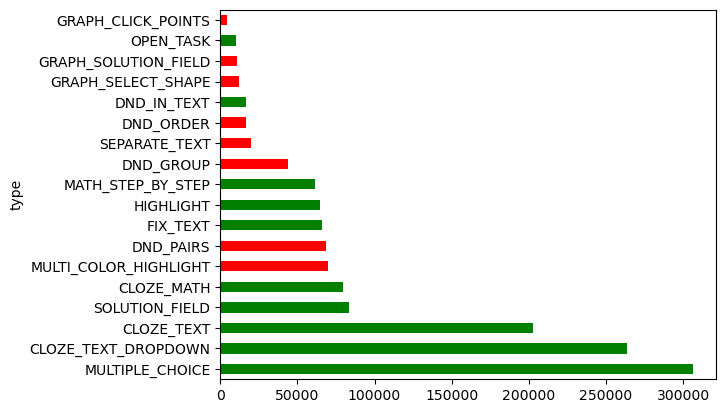

In [6]:
# Based on manual exploration of the files in `examples` folder and the analysis in exploration.md
what_i_think_we_can_use = [
    "CLOZE_MATH",
    "CLOZE_TEXT",
    "CLOZE_TEXT_DROPDOWN",
    "DND_IN_TEXT",
    "FIX_TEXT",
    "HIGHLIGHT",
    "MATH_STEP_BY_STEP",
    "MULTIPLE_CHOICE",
    "OPEN_TASK",
    "SOLUTION_FIELD",
]

# additionally we could use "MULTI_COLOR_HIGHLIGHT"
fig, ax = plt.subplots()
print(f"Total question answers: {unstacked.sum().sum()}")
print(f"Multiple choice question answers: {unstacked['MULTIPLE_CHOICE'].sum()}")
unstacked.sum().sort_values(ascending=False).plot(kind="barh", color=["red" if x not in what_i_think_we_can_use else "green" for x in unstacked.sum().sort_values(ascending=False).index], ax=ax);

Green: data we can use  
Red: data we can't use

In [7]:
print(f"Total of what we can use {unstacked[what_i_think_we_can_use].sum().sum()}")

Total of what we can use 1154196.0


In [8]:
print("Questions per user:")
display(unstacked[what_i_think_we_can_use].sum(axis=1).describe())

Questions per user:


count    21434.000000
mean        53.848838
std        104.735795
min          0.000000
25%          9.000000
50%         25.000000
75%         58.000000
max       7931.000000
dtype: float64

## Merge the data into one dataframe with documents and topic

In [9]:
types_we_can_use = [
    "CLOZE_MATH",
    "CLOZE_TEXT",
    "CLOZE_TEXT_DROPDOWN",
    "DND_IN_TEXT",
    "FIX_TEXT",
    "HIGHLIGHT",
    "MATH_STEP_BY_STEP",
    "MULTIPLE_CHOICE",
    "OPEN_TASK",
    "SOLUTION_FIELD",
]

merged = (
    transactions[[
        "user_id",
        "transaction_id",
        "document_id",
        "document_version",
        "input",
        "type",
        "start_time"
    ]]
    .dropna(subset=["input"])
    .merge(
        documents[[
            "version",
            "document_id",
            "content",
            "topic_id"
        ]].rename({"version": "document_version"}, axis=1),
        on=["document_id", "document_version"],
    )
)

merged = merged[merged["type"].isin(types_we_can_use)]
merged.head(2)

,user_id,transaction_id,document_id,document_version,input,type,start_time,content,topic_id
19,393211,688415,9wk5dtV2mF59odW0wCEYYc,75003,"{""type"": ""CLOZE_TEXT"", ""clozeInputs"": [""Person...",CLOZE_TEXT,2021-05-21 08:07:37.048,"{""id"": ""9wk5dtV2mF59odW0wCEYYc"", ""type"": ""CLOZ...",4256
20,391665,695249,9wk5dtV2mF59odW0wCEYYc,75003,"{""type"": ""CLOZE_TEXT"", ""clozeInputs"": [""Person...",CLOZE_TEXT,2021-05-26 16:34:02.276,"{""id"": ""9wk5dtV2mF59odW0wCEYYc"", ""type"": ""CLOZ...",4256


In [10]:
merged["type"].value_counts()

type
MULTIPLE_CHOICE        306211
CLOZE_TEXT_DROPDOWN    262005
CLOZE_TEXT             202705
SOLUTION_FIELD          83492
CLOZE_MATH              79524
FIX_TEXT                65700
HIGHLIGHT               64918
MATH_STEP_BY_STEP       60174
DND_IN_TEXT             16468
OPEN_TASK                9169
Name: count, dtype: int64

In [11]:
topics = pd.read_csv(
    "{}/topics_translated.csv".format(ORIGINAL_DATA_DIR)
)

merged_with_topics = merged.merge(topics, left_on="topic_id", right_on="id", how="inner")
merged_with_topics.head(2)

,user_id,transaction_id,document_id,document_version,input,type,start_time,content,topic_id,id,german_name,german_description,name,description,math
0,393211,688415,9wk5dtV2mF59odW0wCEYYc,75003,"{""type"": ""CLOZE_TEXT"", ""clozeInputs"": [""Person...",CLOZE_TEXT,2021-05-21 08:07:37.048,"{""id"": ""9wk5dtV2mF59odW0wCEYYc"", ""type"": ""CLOZ...",4256,4256,Tropen und Figuren,NaN,Tropes and figures,NaN,1
1,391665,695249,9wk5dtV2mF59odW0wCEYYc,75003,"{""type"": ""CLOZE_TEXT"", ""clozeInputs"": [""Person...",CLOZE_TEXT,2021-05-26 16:34:02.276,"{""id"": ""9wk5dtV2mF59odW0wCEYYc"", ""type"": ""CLOZ...",4256,4256,Tropen und Figuren,NaN,Tropes and figures,NaN,1


In [12]:
display(merged_with_topics[merged_with_topics["math"] == 0]["user_id"].count())
display(merged_with_topics[merged_with_topics["math"] == 1]["user_id"].count())

735822

414544

Since german data are easier to handler we'll start from those to build our model. If time allows it, we'll try to do the same with the maths data.

In [13]:
data = merged_with_topics[merged_with_topics["math"] == 0]
data.head(2)

,user_id,transaction_id,document_id,document_version,input,type,start_time,content,topic_id,id,german_name,german_description,name,description,math
36867,393224,688626,XoT2lIiIi89AocWKlpqnZ,70625,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""1""...",MULTIPLE_CHOICE,2021-05-21 11:16:29.867,"{""id"": ""XoT2lIiIi89AocWKlpqnZ"", ""type"": ""MULTI...",3163,3163,Komma in Satzgefügen,NaN,Comma in sentence structure,NaN,0
36868,393232,688630,XoT2lIiIi89AocWKlpqnZ,70625,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""0""...",MULTIPLE_CHOICE,2021-05-21 11:16:54.135,"{""id"": ""XoT2lIiIi89AocWKlpqnZ"", ""type"": ""MULTI...",3163,3163,Komma in Satzgefügen,NaN,Comma in sentence structure,NaN,0


In [16]:
from pathlib import Path

Path("{}/preprocessed".format(BASE_DATA_DIR)).mkdir(parents=True, exist_ok=True)
data.to_csv("{}/preprocessed/german_data_merged.csv".format(BASE_DATA_DIR))

## Build the question/answer pairs dataset

In [17]:
from functools import partial, reduce

def pipe(*funcs):
    return partial(reduce, lambda r, f: f(r), funcs)

In [18]:
import string
import json

def preprocess_multiple_choice(x):
    """
        This function takes a row from the dataframe and returns a series with the following columns:
        - multiple_responses: boolean, whether the question allows multiple responses
        - question: the question text
        - choices: list of choices available to the student
        - student_answer: list of booleans, whether the student selected the choice
        - user_id: the user id

        The function assumes that the input and content columns are json strings structured as can be found in the examples folder.
    """

    input_ = json.loads(x["input"])
    content = json.loads(x["content"])
    # display(x)
    return pd.Series({
        "multiple_responses": content["multipleResponses"],
        "question": content["description"],
        "choices": list(map(lambda c: c["content"], content["choices"])),
        "correct": list(map(lambda c: c["correct"], content["choices"])),
        "student_answer": [input_["selections"].get(str(i), False) for i in range(len(content["choices"]))],
        "start_time": x["start_time"],
        "user_id": x["user_id"],
    })

def student_answer_bool_to_letters(x):
    """
        This utility converts the student answer from a list of booleans to a list of letters.
    """

    letters = np.array(list(string.ascii_uppercase))
    x["student_answer"] = ", ".join(letters[:len(x["student_answer"])][x["student_answer"]])
    return x

def expand_choices(x):
    """
        This utility expands the choices into separate columns.
    """

    for i, c in enumerate(x["choices"]):
        x[f"choice_{i}"] = c
    return x.drop("choices")

preprocessing_functions = {
    "MULTIPLE_CHOICE": pipe(
        preprocess_multiple_choice,
        # student_answer_bool_to_letters,
        # expand_choices
    ),
}

In [22]:
# usage example
data[data["type"] == "MULTIPLE_CHOICE"][["input", "content", "user_id", "start_time"]].iloc[[0]].apply(preprocessing_functions["MULTIPLE_CHOICE"], axis=1)

,multiple_responses,question,choices,correct,student_answer,start_time,user_id
36867,True,Markiere die Sätze mit der korrekten Kommasetz...,[<table><tbody><tr><td><p>Im „hessischen Landb...,"[False, False, False, True]","[False, False, False, False]",2021-05-21 11:16:29.867,393224


### Process the data

In [25]:
Path(f"{BASE_DATA_DIR}/lernnavi/qna").mkdir(parents=True, exist_ok=True)

for task_type in preprocessing_functions.keys():
    cur = data[data["type"] == task_type]
    cur[["input", "content", "user_id", "start_time"]].apply(preprocessing_functions[task_type], axis=1).to_pickle(f"{BASE_DATA_DIR}/lernnavi/qna/{task_type}_german.pkl")

MCQs don't always have the same number of answers. We'll have to deal with that.

In [26]:
numselections = data[data["type"] == "MULTIPLE_CHOICE"]["input"].apply(lambda x: pd.Series([x, sum(json.loads(x)["selections"].values())]))
numselections.describe()

,1
count,138149.000000
mean,1.599556
std,0.878123
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,9.000000


In [27]:
numchoices = data[data["type"] == "MULTIPLE_CHOICE"]["content"].apply(lambda x: pd.Series([x, len(json.loads(x)["choices"])]))
numchoices.describe()

,1
count,138149.000000
mean,3.917379
std,0.994844
min,2.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,11.000000
